In [ ]:
!pip install scikit-surprise
#import libraries
import surprise
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, BaselineOnly, KNNBaseline, SVDpp
from surprise.model_selection import cross_validate
from surprise.model_selection.search import GridSearchCV, RandomizedSearchCV
import random
from datetime import datetime
import pickle
from scipy import sparse
from scipy.sparse import csr_matrix
import xgboost as xgb
from xgboost import XGBRegressor
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
import matplotlib as plt
import tensorflow as tf

     |████████████████████████████████| 11.8MB 305kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670926 sha256=8df50410708d93807f0662aab349ec52226a386ab5acc05a69367ce34bfc58cb
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
raw_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Data/Dataset_MAT_CLI_2019_2020.xlsx', sheet_name='sub_linha')
print('Tamanho total do dataset '+str(len(raw_data)))

Tamanho total do dataset 314720


In [ ]:
raw_data_copy = raw_data.copy()

In [ ]:
#raw_data = raw_data_copy.copy()

In [ ]:
#' Material - Código'

In [ ]:
raw_data.rename(columns={'Cliente - Código': 'cod_cli','Subsis_Linha':'cod_mat','Valor Receita Bruta (- Devolução)':'volume' }, inplace=True  )

In [ ]:
raw_data_copy.rename(columns={'Cliente - Código': 'cod_cli','Subsis_Linha':'cod_mat','Valor Receita Bruta (- Devolução)':'volume' }, inplace=True  )

In [ ]:
pickle.dump(raw_data_copy, open("/content/drive/My Drive/Colab Notebooks/Data/dataframe.pickle","wb"))
raw_data.head()

In [ ]:
raw_data.columns

Index(['cod_mat', 'cod_cli', 'top80perc', 'top90perc', 'volume',
       'Grupo de Cliente', 'Cluster'],
      dtype='object')

In [ ]:
raw_data = raw_data[(raw_data.top80perc == 1 ) & (raw_data.Cluster == 1) & (raw_data['Grupo de Cliente'] == 'Varejo')].copy()

In [ ]:
raw_data.drop(columns = ['top80perc', 'top90perc','Grupo de Cliente','Cluster'], inplace = True)

In [ ]:
print('Numero total de Clientes analisados: ',raw_data.cod_cli.nunique() )


Numero total de Clientes analisados:  3185


In [ ]:
print('Numero total de Materiais analisados: ',raw_data.cod_mat.nunique() )

Numero total de Materiais analisados:  46


In [ ]:
raw_data.shape

(53402, 3)

In [ ]:
#limpeza dos dados, retirar devoluções e outliers

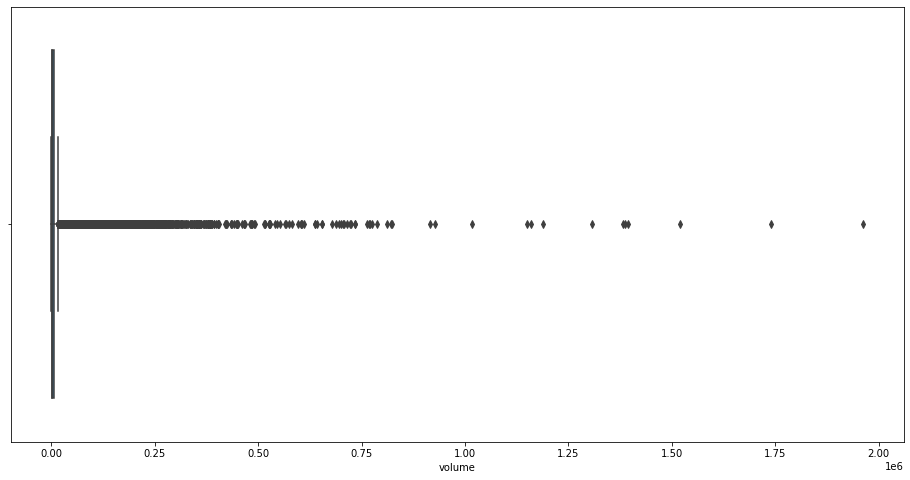

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x=raw_data.volume)

In [ ]:
# = raw_data_copy.copy()

In [ ]:
#Retirada dos valores de devolução
raw_data = raw_data[raw_data.volume >= 1000]

In [ ]:
#Formatting Float values for a better visualization
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
total_rows = raw_data.shape[0]

In [ ]:
#Retirada dos outliers
#Find Outlier values
mean = raw_data.volume[(raw_data.volume < raw_data.volume.quantile(0.95)) & (raw_data.volume > raw_data.volume.quantile(0.05))].mean()
std = raw_data.volume[(raw_data.volume < raw_data.volume.quantile(0.95)) & (raw_data.volume > raw_data.volume.quantile(0.05))].std()
out_plus = abs((mean + std*2.5))
out_less = (mean - std*2.5)

print('out plus: ',out_plus,'out less: ',out_less,'max: ', max(raw_data.volume), 'min: ', min(raw_data.volume))

out plus:  37957.42930442279 out less:  -19913.669757705713 max:  1961856.7699999998 min:  1000.0


In [ ]:
outliers =  (mean + std*2.5) < raw_data.volume
raw_data.volume[outliers] = np.nan
#SP_results.fillna(0, inplace=True)
#SP_results.fillna(median, inplace=True)
#raw_data.volume.fillna((mean + std*2.5), inplace=True)
#raw_data.dropna(inplace=True)
raw_data.fillna(mean, inplace=True)
raw_data.describe()

,cod_cli,volume
count,"40,006.00","40,006.00"
mean,"1,051,190.90","6,949.48"
std,"33,520.79","7,057.46"
min,"1,000,003.00","1,000.00"
25%,"1,028,989.50","2,155.01"
50%,"1,046,546.00","4,333.09"
75%,"1,059,347.00","9,021.88"
max,"1,152,742.00","37,955.90"


In [ ]:
#Perda de dados:
print(1- (raw_data.shape[0]/total_rows))

0.0


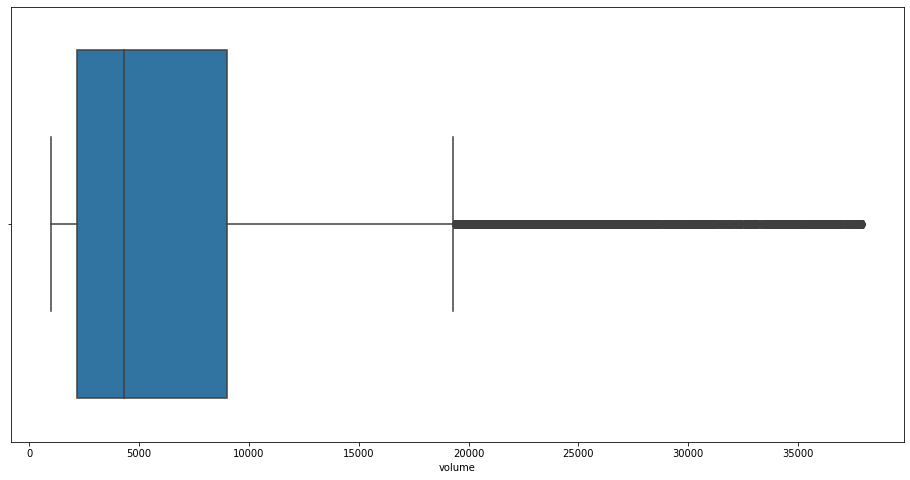

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(x=raw_data.volume)

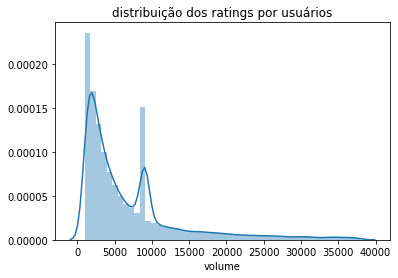

In [ ]:
ax = sns.distplot(raw_data.volume)
plot_is = ax.set(title='distribuição dos ratings por usuários')

In [ ]:
#volume total por cliente
grouped_data = raw_data.groupby('cod_cli')['volume'].sum()

In [ ]:
grouped_data2 = raw_data.groupby('cod_cli')['cod_mat'].nunique()

In [ ]:
raw_data = pd.merge(raw_data,grouped_data, right_index=False,suffixes=('','_total') , left_index=True,how='left', on= 'cod_cli')

In [ ]:
raw_data = pd.merge(raw_data,grouped_data2, right_index=False,suffixes=('','_total') , left_index=True,how='left', on= 'cod_cli')

In [ ]:
raw_data['volume_perc'] = raw_data['volume']/raw_data['volume_total']

In [ ]:
raw_data['mat_perc'] = 1/raw_data['cod_mat_total']

In [ ]:
#raw_data.drop(columns=['top80perc','top90perc'], inplace =True)

In [ ]:
raw_data.head()

In [ ]:
raw_data.describe()

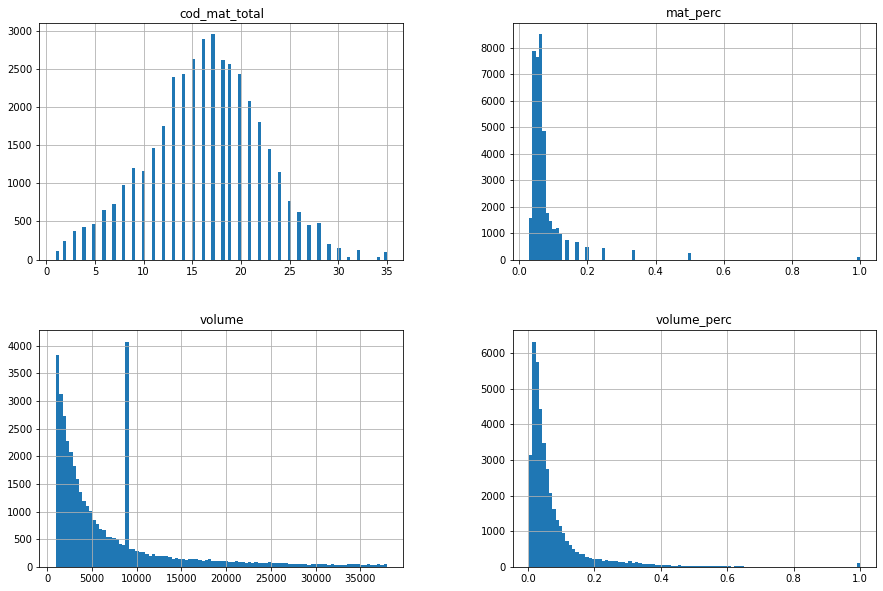

In [ ]:
import matplotlib.pyplot as plt
raw_data[['volume_perc','cod_mat_total','mat_perc','volume']].hist(bins=100, figsize=(15,10))
plt.show()

In [ ]:
# Split 70/30
train_df,test_df = train_test_split(raw_data, test_size=0.3,random_state=42)

In [ ]:
print("Train: ", train_df.shape)
print("test: ", test_df.shape)

Train:  (266811, 7)
test:  (114348, 7)


In [ ]:
train_df_structured =[]
test_df_structured =[]

In [ ]:
# média global do training set
print("Média global (training): ", train_df.volume.mean())

Média global (training):  1045.906477431577


In [ ]:
# média global do test set
print("Média global (test): ", test_df.volume.mean())

Média global (test):  1044.5840206212586


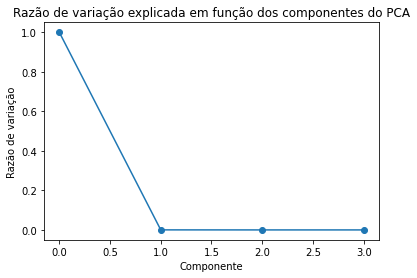

In [ ]:
#Agrupando as features por PCA
from sklearn.decomposition import PCA
features = train_df[['volume', 'volume_total', 'cod_mat_total',
       'volume_perc', 'mat_perc']].values
dataset_pca = PCA(n_components=4)
dataset_pca.fit(features)
plt.plot(list(dataset_pca.explained_variance_ratio_),'-o')
plt.title('Razão de variação explicada em função dos componentes do PCA')
plt.ylabel('Razão de variação')
plt.xlabel('Componente')
plt.show()



In [ ]:
#Aplicando as redução no dataset
reduction_pca = PCA(n_components=1)
reduced_features = reduction_pca.fit_transform(features)

In [ ]:
train_df_structured = train_df.copy()

In [ ]:
train_df_structured['gavg'] = 1

In [ ]:
for idx,i in enumerate(reduced_features):
  train_df_structured['gavg'].iloc[idx] = i

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
# Média volume por cliente treino
train_df_grp_cli = train_df.groupby(by='cod_cli')
train_average_cliente_materiais={}
for i , j in train_df_grp_cli:
  train_average_cliente_materiais[i]=j.volume.mean()
print("Média volume por Cliente: ", len(train_df_grp_cli))

Média volume por Cliente:  9981


In [ ]:
# Média volume por cliente teste
test_df_grp_cli = test_df.groupby(by='cod_cli')
test_average_cliente_materiais={}
for i , j in test_df_grp_cli:
  test_average_cliente_materiais[i]=j.volume.mean()
print("Média volume por Cliente: ", len(test_df_grp_cli))

Média volume por Cliente:  9319


In [ ]:
train_df_grp_mat = train_df.groupby(by='cod_mat')
train_average_mat_volume={}
for i , j in train_df_grp_mat:
  train_average_mat_volume[i]=j.volume.mean()
print("Média por material treino: ", len(train_df_grp_mat))

Média por material treino:  305


In [ ]:
test_df_grp_mat = test_df.groupby(by='cod_mat')
test_average_mat_volume={}
for i , j in test_df_grp_mat:
  test_average_mat_volume[i]=j.volume.mean()
print("Média por material teste: ", len(test_df_grp_mat))

Média por material teste:  301


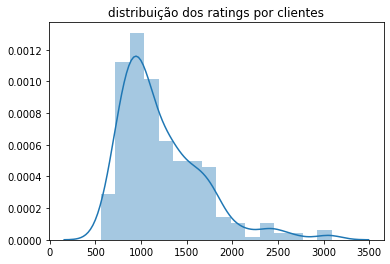

In [ ]:
ax = sns.distplot([*train_average_mat_volume.values()])
plot_is = ax.set(title='distribuição dos ratings por clientes')

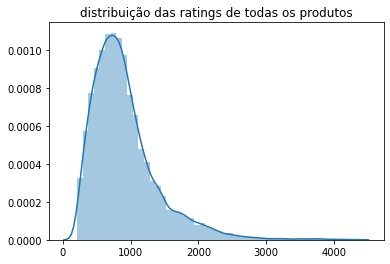

In [ ]:
ax = sns.distplot([*train_average_cliente_materiais.values()])
plot_is = ax.set(title='distribuição das ratings de todas os produtos')

In [ ]:
# Criando nossa estrutura para alimentar modelo - teste
test_df_structured = test_df.copy()
#test_df_structured['gavg'] = test_df.volume.mean()

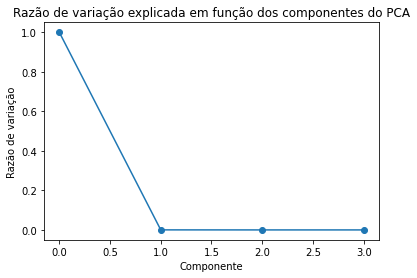

In [ ]:
#Agrupando as features por PCA
from sklearn.decomposition import PCA
features = test_df[['volume', 'volume_total', 'cod_mat_total',
       'volume_perc', 'mat_perc']].values
dataset_pca = PCA(n_components=4)
dataset_pca.fit(features)
plt.plot(list(dataset_pca.explained_variance_ratio_),'-o')
plt.title('Razão de variação explicada em função dos componentes do PCA')
plt.ylabel('Razão de variação')
plt.xlabel('Componente')
plt.show()



In [ ]:
#Aplicando as redução no dataset
reduction_pca = PCA(n_components=1)
reduced_features_test = reduction_pca.fit_transform(features)

In [ ]:
test_df_structured['gavg'] = 1

In [ ]:
for idx,i in enumerate(reduced_features_test):
  test_df_structured['gavg'].iloc[idx] = i

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
test_df_structured.head()

In [ ]:
tmp_avg_cli_test = pd.DataFrame.from_dict(test_average_cliente_materiais,orient='index')
tmp_avg_cli_test.reset_index(inplace=True)
tmp_avg_cli_test.rename(columns= {'index':'cod_cli',0:'avg_cli',}, inplace = True )



In [ ]:
test_df_structured = pd.merge(test_df_structured,tmp_avg_cli_test, right_index=False, left_index=True,how='left', on= 'cod_cli')

In [ ]:
tmp_avg_mat_test = pd.DataFrame.from_dict(test_average_mat_volume,orient='index')
tmp_avg_mat_test.reset_index(inplace=True)
tmp_avg_mat_test.rename(columns= {'index':'cod_mat',0:'avg_mat'}, inplace = True )

In [ ]:
test_df_structured = pd.merge(test_df_structured,tmp_avg_mat_test, right_index=False, left_index=True,how='left' , on= 'cod_mat')

In [ ]:
test_df_structured.head()

In [ ]:
tmp_avg_cli = pd.DataFrame.from_dict(train_average_cliente_materiais,orient='index')
tmp_avg_cli.reset_index(inplace=True)
tmp_avg_cli.rename(columns= {'index':'cod_cli',0:'avg_cli'}, inplace = True )



In [ ]:
train_df_structured = pd.merge(train_df_structured,tmp_avg_cli, right_index=False, left_index=True,how='left', on= 'cod_cli')

In [ ]:
tmp_avg_mat = pd.DataFrame.from_dict(train_average_mat_volume,orient='index')
tmp_avg_mat.reset_index(inplace=True)
tmp_avg_mat.rename(columns= {'index':'cod_mat',0:'avg_mat'}, inplace = True )

In [ ]:
train_df_structured = pd.merge(train_df_structured,tmp_avg_mat, right_index=False, left_index=True,how='left' , on= 'cod_mat')

In [ ]:
train_df_structured.head()

In [ ]:
#Definindo uma amostra Treino
import numpy as np

# Apenas para ilustração. Sklearn possui a função train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))

    test_set_size = int(len(data) * test_ratio)

    test_indices = shuffled_indices[:test_set_size]

    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_df_structured_bk = train_df_structured.copy()
test_df_structured_bk = test_df_structured.copy()

In [ ]:
#train_df_structured = train_df_structured_bk.copy()
#test_df_structured = test_df_structured_bk.copy()

In [ ]:
#Definindo uma amostra Treino
shuffled_indices = np.random.permutation(len(train_df_structured))
train_indices = shuffled_indices[0:]
train_df_structured = train_df_structured.iloc[train_indices]

In [ ]:
#Definindo uma amostra Teste
shuffled_indices = np.random.permutation(len(test_df_structured))
test_indices = shuffled_indices[0:]
test_df_structured = test_df_structured.iloc[test_indices]

In [ ]:
train_df_bk = train_df.copy()
test_df_bk  = test_df.copy()

In [ ]:
#Definindo uma amostra Treino
shuffled_indices = np.random.permutation(len(train_df))
train_indices = shuffled_indices[0:]
train_df = train_df.iloc[train_indices]

In [ ]:
#Definindo uma amostra Teste
shuffled_indices = np.random.permutation(len(test_df))
test_indices = shuffled_indices[0:]
test_df = test_df.iloc[test_indices]

In [ ]:
train_df.columns


Index(['cod_cli', 'cod_mat', 'volume', 'volume_total', 'cod_mat_total',
       'volume_perc', 'mat_perc'],
      dtype='object')

Normalizando os dados

In [ ]:
#Min-Max scaling Metodo para Array:
from sklearn.preprocessing import MinMaxScaler

MinMax = MinMaxScaler()
train_df["volume_perc"] = MinMax.fit_transform(train_df["volume_perc"].to_numpy().reshape(-1, 1))
train_df["mat_perc"] = MinMax.fit_transform(train_df["mat_perc"].to_numpy().reshape(-1, 1))
train_df["cod_mat_total"] = MinMax.fit_transform(train_df["cod_mat_total"].to_numpy().reshape(-1, 1))
train_df["volume_total"] = MinMax.fit_transform(train_df["volume_total"].to_numpy().reshape(-1, 1))
train_df["volume"] = MinMax.fit_transform(train_df["volume"].to_numpy().reshape(-1, 1))


test_df["volume_perc"] = MinMax.fit_transform(test_df["volume_perc"].to_numpy().reshape(-1, 1))
test_df["mat_perc"] = MinMax.fit_transform(test_df["mat_perc"].to_numpy().reshape(-1, 1))
test_df["cod_mat_total"] = MinMax.fit_transform(test_df["cod_mat_total"].to_numpy().reshape(-1, 1))
test_df["volume_total"] = MinMax.fit_transform(test_df["volume_total"].to_numpy().reshape(-1, 1))
test_df["volume"] = MinMax.fit_transform(test_df["volume"].to_numpy().reshape(-1, 1))


In [ ]:
train_df_structured["gavg"] = MinMax.fit_transform(train_df_structured["gavg"].to_numpy().reshape(-1, 1))

test_df_structured["gavg"] = MinMax.fit_transform(test_df_structured["gavg"].to_numpy().reshape(-1, 1))

In [ ]:
#Min-Max scaling Metodo para Array:
from sklearn.preprocessing import MinMaxScaler

MinMax = MinMaxScaler()

train_df_structured["volume_perc"] = MinMax.fit_transform(train_df_structured["volume_perc"].to_numpy().reshape(-1, 1))
train_df_structured["mat_perc"] = MinMax.fit_transform(train_df_structured["mat_perc"].to_numpy().reshape(-1, 1))
train_df_structured["cod_mat_total"] = MinMax.fit_transform(train_df_structured["cod_mat_total"].to_numpy().reshape(-1, 1))
train_df_structured["volume_total"] = MinMax.fit_transform(train_df_structured["volume_total"].to_numpy().reshape(-1, 1))
train_df_structured["volume"] = MinMax.fit_transform(train_df_structured["volume"].to_numpy().reshape(-1, 1))

test_df_structured["volume_perc"] = MinMax.fit_transform(test_df_structured["volume_perc"].to_numpy().reshape(-1, 1))
test_df_structured["mat_perc"] = MinMax.fit_transform(test_df_structured["mat_perc"].to_numpy().reshape(-1, 1))
test_df_structured["cod_mat_total"] = MinMax.fit_transform(test_df_structured["cod_mat_total"].to_numpy().reshape(-1, 1))
test_df_structured["volume_total"] = MinMax.fit_transform(test_df_structured["volume_total"].to_numpy().reshape(-1, 1))
test_df_structured["volume"] = MinMax.fit_transform(test_df_structured["volume"].to_numpy().reshape(-1, 1))

In [ ]:
test_df_structured["avg_cli"] = MinMax.fit_transform(test_df_structured["avg_cli"].to_numpy().reshape(-1, 1))
train_df_structured["avg_mat"] = MinMax.fit_transform(train_df_structured["avg_mat"].to_numpy().reshape(-1, 1))

test_df_structured["avg_cli"] = MinMax.fit_transform(test_df_structured["avg_cli"].to_numpy().reshape(-1, 1))
train_df_structured["avg_mat"] = MinMax.fit_transform(train_df_structured["avg_mat"].to_numpy().reshape(-1, 1))

In [ ]:
train_df_structured.head()

In [ ]:
test_df_structured.head()

Criando as variaveis 'target' para o train

In [ ]:
#Criando as variaveis 'target' para o train
train_df_structured_target = train_df.volume
train_df_structured.drop(columns=['volume','cod_cli','cod_mat'], inplace = True)
pickle.dump(train_df_structured_target, open("/content/drive/My Drive/Colab Notebooks/Data/train_df_structured_target.pickle","wb"))
#Criando as variaveis 'target' para o test
test_df_structured_target = test_df_structured.volume
test_df_structured.drop(columns=['volume','cod_cli','cod_mat'], inplace = True)
pickle.dump(test_df_structured_target, open("/content/drive/My Drive/Colab Notebooks/Data/test_df_structured_target.pickle","wb"))

### Criando nosso modelo:

In [ ]:
global_model_name={}

In [ ]:
# define error metric
def _error(actual: np.ndarray, predicted: np.ndarray):
    """ atributo de erro simples"""
    return actual - predicted

def mae(actual: np.ndarray, predicted: np.ndarray):
    """ erro médio absoluto """
    return np.mean(np.abs(_error(actual, predicted)))

def nmae(actual: np.ndarray, predicted: np.ndarray):
    """ erro médio absoluto normalizado """
    return mae(actual, predicted) / (actual.max() - actual.min())

def get_ratings(predictions):
    """ retornar os ratings depois que o modelo ficar pronto"""
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    return actual, pred

In [ ]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(min(train_df.volume) , max(train_df.volume)))
# create the traindata from the dataframe...
train_data = Dataset.load_from_df(train_df[['cod_cli', 'cod_mat', 'volume']], reader)
# build the trainset from traindata.., It is of dataset format from surprise␣library..
trainset = train_data.build_full_trainset()
testset = list(zip(test_df.cod_cli.values, test_df.cod_mat.values, test_df.volume.values))
print("Algumas amostras do test")
testset[:3]

Algumas amostras do test


[(1067629, 33048513, 0.03169636979497062),
 (1041169, 35308369, 0.17210259847514642),
 (1014982, 27950345, 0.3175741181821447)]

In [ ]:
pickle.dump(train_data, open("/content/drive/My Drive/Colab Notebooks/Data/train_data_sp.pickle","wb"))
pickle.dump(trainset, open("/content/drive/My Drive/Colab Notebooks/Data/trainset_sp.pickle","wb"))
pickle.dump(testset, open("/content/drive/My Drive/Colab Notebooks/Data/testset.pickle","wb"))

In [ ]:
param_grid = {
'bsl_options' :{
'method':['sgd'],
'learning_rate': [.001,.01,.1],
'n_epochs':[5,7,9,10,20]
},
'verbose' : [False]
}
rs = GridSearchCV(BaselineOnly, param_grid, cv=3, joblib_verbose=4, n_jobs=-1)
rs.fit(train_data)
print(rs.best_params['mae'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min


{'bsl_options': {'method': 'sgd', 'learning_rate': 0.01, 'n_epochs': 20}, 'verbose': False}


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.8min finished


In [ ]:
bsl_options = {'method': 'sgd',
               'learning_rate': 0.01,
               'n_epochs' : 20
              }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
bsl_algo.fit(trainset)
train_preds = bsl_algo.test(trainset.build_testset())
train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
test_preds = bsl_algo.test(testset)
test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
train_df_structured['BaselineOnly'] = train_pred_ratings
test_df_structured['BaselineOnly'] = test_pred_ratings
global_model_name['Baseline']= {"Train" : nmae(train_pred_ratings,train_actual_ratings),
                                "Test" : nmae(test_pred_ratings,test_actual_ratings)
                                }
print('O Resultado: ')
print(global_model_name['Baseline'])

Estimating biases using sgd...
O Resultado: 
{'Train': 0.15943233114470798, 'Test': 0.1639012704348767}


In [ ]:
# Salvando o modelo:
pickle.dump(bsl_algo, open("/content/drive/My Drive/Colab Notebooks/Data/bsl_algo.pickle","wb"))

In [ ]:
# Modelo KNN Baseline

param_grid = {
'bsl_options' :{'method': ['sgd'],
'learning_rate': [0.001,00.1,01]
},
'sim_options' : {'user_based' : [False],
'name': ['cosine'],
'shrinkage': [100],
'min_support': [2]
},
'k' : [40,50,60,70],
'verbose' : [False]
}
rs = GridSearchCV(KNNBaseline, param_grid, cv=3, joblib_verbose=1, n_jobs=-1)
rs.fit(train_data)
print(rs.best_params)
print(rs.best_params['mae'])

# Vamos utilizar o parametro ótimo de K (baseado no MAE) para treinar o modelo

bsl_options = {'method': 'sgd',
'learning_rate': 0.001
}
sim_options = {'user_based' : False,
'name': 'cosine',
'shrinkage': 100,
'min_support': 2
}
knn_bsl_u = KNNBaseline(k=60, sim_options = sim_options, bsl_options =bsl_options)
knn_bsl_u.fit(trainset)
train_preds = knn_bsl_u.test(trainset.build_testset())
train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
test_preds = knn_bsl_u.test(testset)
test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
train_df_structured['KnnBaseline_Mat'] = train_pred_ratings
test_df_structured['KnnBaseline_Mat'] = test_pred_ratings
global_model_name['KnnBaseline_Mat']={
"Train": nmae(train_pred_ratings,train_actual_ratings),
"Test": nmae(test_pred_ratings,test_actual_ratings)
}
print('Resultado do modelo: ')
print(global_model_name['KnnBaseline_Mat'])

# Salvando modelo
pickle.dump(knn_bsl_u, open("/content/drive/My Drive/Colab Notebooks/Data/knn_bsl_u.pickle","wb"))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.0min finished


{'rmse': {'bsl_options': {'method': 'sgd', 'learning_rate': 0.001}, 'sim_options': {'user_based': False, 'name': 'cosine', 'shrinkage': 100, 'min_support': 2}, 'k': 40, 'verbose': False}, 'mae': {'bsl_options': {'method': 'sgd', 'learning_rate': 0.001}, 'sim_options': {'user_based': False, 'name': 'cosine', 'shrinkage': 100, 'min_support': 2}, 'k': 40, 'verbose': False}}
{'bsl_options': {'method': 'sgd', 'learning_rate': 0.001}, 'sim_options': {'user_based': False, 'name': 'cosine', 'shrinkage': 100, 'min_support': 2}, 'k': 40, 'verbose': False}
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Resultado do modelo: 
{'Train': 0.12713038366242196, 'Test': 0.13269515860725267}


In [ ]:
# Modelo XGBoost
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
params = {
'min_child_weight': [1, 3, 5, 10],
'gamma': [0.5, 1, 1.5, 2, 5],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.6, 0.8, 1.0],
'max_depth': [3, 4, 5],
'eta':[0.02,0.01,0.1],
'n_estimators' : [100, 200, 400, 600, 800],
'learning_rate' : [0.001,0.001,0.01,0.1]
}
xgb = XGBRegressor()
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10,scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=10,random_state=42)
random_search.fit(train_df_structured, train_df_structured_target)
print(random_search.best_params_)

xgb_bsl = XGBRegressor(min_child_weight = 5 ,gamma = 5, subsample = 1.0,colsample_bytree = 0.8,
max_depth = 5,eta = 0.1,n_estimators = 100,learning_rate = 0.1,
objective='reg:squarederror',silent=True, random_state=42)
xgb_bsl.fit(train_df_structured, train_df_structured_target)
test_pred_ratings = xgb_bsl.predict(test_df_structured)
train_pred_ratings = xgb_bsl.predict(train_df_structured)
global_model_name['First_XGB']={
"Train": mae(train_pred_ratings,train_df_structured_target),
"Test": mae(test_pred_ratings,test_df_structured_target)
}
print('Resultados do modelo: ')
print(global_model_name['First_XGB'])

# Salvando o modelo:
pickle.dump(xgb_bsl, open("/content/drive/My Drive/Colab Notebooks/Data/xgb_bsl.pickle","wb"))



Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 29.9min finished


[01:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'subsample': 1.0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 1.5, 'eta': 0.02, 'colsample_bytree': 1.0}
Resultados do modelo: 
{'Train': 0.1695543020611942, 'Test': 0.16941579091689155}


In [ ]:
### Modelo SVD (surprise)
#from surprise.model_selection.search import GridSearchCV, RandomizedSearchCV
from surprise import SVD
param_distributions = {
'n_factors' : [100,250,500,1000,2000,3000,5000],
'verbose' : [False],
'lr_bu' : [0.001,0.01,0.005],
'lr_bi' : [0.001,0.01,0.005],
'lr_pu' : [0.001,0.01,0.005],
'lr_qi' : [0.001,0.01,0.005],
'reg_bu' : [0.01,0.001],
'reg_bi' : [0.01,0.001],
'reg_pu' : [0.01,0.001],
'reg_qi' : [0.01,0.001]
}
#rs = RandomizedSearchCV(SVD, param_distributions, n_iter=20, cv=3,joblib_verbose=1,n_jobs=10, random_state=42)#n_jobs=-1
#rs.fit(train_data)
#print(rs.best_params)
#print(rs.best_params['mae'])
# Vamos utilizar o valor ótimo
# Inicializando o modelo:




In [ ]:
### XGBoost V2
# Vamos usar a média, média global, média das piadas, a similaridade do output do knn, do Baseline, e do SVD
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
params = {
'min_child_weight': [1, 3, 5, 10],
'gamma': [0.5, 1, 1.5, 2, 5],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.6, 0.8, 1.0],
'max_depth': [3, 4, 5],
'eta':[0.02,0.01,0.1],
'n_estimators' : [100, 200, 400, 600, 800],
'learning_rate' : [0.001,0.001,0.01,0.1]
}
xgb = XGBRegressor()
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10,scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=10,random_state=42)
random_search.fit(train_df_structured, train_df_structured_target)
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 21.8min finished


[22:50:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'subsample': 1.0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 1.5, 'eta': 0.02, 'colsample_bytree': 1.0}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
xgb = XGBRegressor()

In [ ]:
svd = SVD(n_factors=2000,biased=False, random_state=42, verbose=True,
lr_bu = 0.001, lr_bi = 0.01, lr_pu = 0.01, lr_qi = 0.01,
reg_bu = 0.001, reg_bi = 0.001, reg_pu = 0.001, reg_qi = 0.001
)
svd.fit(trainset)
train_preds = svd.test(trainset.build_testset())
train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
test_preds = svd.test(testset)
test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
train_df_structured['SVD'] = train_pred_ratings
test_df_structured['SVD'] = test_pred_ratings
global_model_name['SVD']={
"Train" : nmae(train_pred_ratings,train_actual_ratings),
"Test" : nmae(test_pred_ratings,test_actual_ratings)
}
print('Resultado do modelo: ')
print(global_model_name['SVD'])
# Salvando o modleo:
pickle.dump(svd, open("/content/drive/My Drive/Colab Notebooks/Data/svd.pickle","wb"))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Resultado do modelo: 
{'Train': 0.010588431721334621, 'Test': 0.2092318366784763}


In [ ]:
xgb = XGBRegressor()
params = {
'min_child_weight': [1, 3, 5, 10],
'gamma': [0.5, 1, 1.5, 2, 5],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.6, 0.8, 1.0],
'max_depth': [3, 4, 5],
'eta':[0.02,0.01,0.1],
'n_estimators' : [100, 200, 400, 600, 800],
'learning_rate' : [0.001,0.001,0.01,0.1]
}
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10,scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=10,random_state=42)
random_search.fit(train_df_structured, train_df_structured_target)
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 24.5min finished


[23:24:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'subsample': 1.0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 1.5, 'eta': 0.02, 'colsample_bytree': 1.0}


In [ ]:
# inicializando o modelo XGBoost...
xgb_svd = XGBRegressor(min_child_weight = 1 ,gamma = 1.5, subsample = 1.0,colsample_bytree = 1.0,
max_depth = 4,eta = 0.02,n_estimators = 200,learning_rate = 0.1,
objective='reg:squarederror',silent=True, random_state=42)
xgb_svd.fit(train_df_structured, train_df_structured_target)
test_pred_ratings = xgb_svd.predict(test_df_structured)
train_pred_ratings = xgb_svd.predict(train_df_structured)
global_model_name['Second_XGB']={
"Train": mae(train_pred_ratings,train_df_structured_target),
"Test": mae(test_pred_ratings,test_df_structured_target)
}
print('Resultado do modelo: ')
print(global_model_name['Second_XGB'])

# Salvando o modelo
pickle.dump(xgb_svd, open("/content/drive/My Drive/Colab Notebooks/Data/xgb_svd.pickle","wb"))

# Verificando feature importance:
#print(xgb_bsl.feature_importances_)
print(train_df_structured.columns)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


Resultado do modelo: 
{'Train': inf, 'Test': inf}
Index(['volume_total', 'cod_mat_total', 'volume_perc', 'mat_perc', 'gavg',
       'avg_cli', 'avg_mat', 'BaselineOnly', 'KnnBaseline_Mat', 'SVD'],
      dtype='object')


In [ ]:
## Feature Engineering

train_df_structured['special_feature'] =train_df_structured['avg_cli']+train_df_structured['avg_mat'] - 1#-train_df_structured['gavg']
test_df_structured['special_feature'] =test_df_structured['avg_cli']+test_df_structured['avg_mat']    - 1 #test_df_structured['gavg']
train_df_structured.head()

,volume_total,cod_mat_total,volume_perc,mat_perc,gavg,avg_cli,avg_mat,BaselineOnly,KnnBaseline_Mat,SVD,special_feature
204,0.33,0.52,0.01,0.01,0.33,"1,207.32",0.11,0.20,0.20,0.07,"1,206.44"
107,0.20,0.42,0.01,0.01,0.20,860.59,0.23,0.22,0.22,0.03,859.83
261,0.29,0.58,0.01,0.00,0.29,833.75,0.14,0.19,0.21,0.75,832.89
128,0.68,0.85,0.01,0.00,0.68,"1,367.03",0.07,0.11,0.06,0.05,"1,366.10"
111,0.48,0.68,0.00,0.00,0.48,"1,380.40",0.09,0.11,0.08,0.13,"1,379.49"


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
params = {
'min_child_weight': [1, 3, 5, 10],
'gamma': [0.5, 1, 1.5, 2, 5],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.6, 0.8, 1.0],
'max_depth': [3, 4, 5],
'eta':[0.02,0.01,0.1],
'n_estimators' : [100, 200, 400, 600, 800],
'learning_rate' : [0.001,0.001,0.01,0.1]
}
xgb = XGBRegressor()
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10,scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=10,random_state=42)
random_search.fit(train_df_structured, train_df_structured_target)
print(random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 26.2min finished


[23:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'subsample': 1.0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 1.5, 'eta': 0.02, 'colsample_bytree': 1.0}


In [ ]:
# Inicializando modelo XGBoost...
xgb_bsl_fe_1 = XGBRegressor(min_child_weight = 5 ,gamma = 5, subsample = 1.0,colsample_bytree = 0.8,
max_depth = 5,eta = 0.1,n_estimators = 200,learning_rate = 0.1,
objective='reg:squarederror',silent=True, random_state=42)
xgb_bsl_fe_1.fit(train_df_structured, train_df_structured_target)
test_pred_ratings = xgb_bsl_fe_1.predict(test_df_structured)
train_pred_ratings = xgb_bsl_fe_1.predict(train_df_structured)
global_model_name['First_XGB_FE_1']={
"Train": mae(train_pred_ratings,train_df_structured_target),
"Test": mae(test_pred_ratings,test_df_structured_target)
}
print('Resultado do modleo: ')
print(global_model_name['First_XGB_FE_1'])

Resultado do modleo: 
{'Train': 0.1695517722780586, 'Test': 0.16941324300424618}


In [ ]:
print(xgb_bsl_fe_1.feature_importances_)
print(train_df_structured.columns)

[nan nan nan nan nan nan nan nan nan nan nan]
Index(['volume_total', 'cod_mat_total', 'volume_perc', 'mat_perc', 'gavg',
       'avg_cli', 'avg_mat', 'BaselineOnly', 'KnnBaseline_Mat', 'SVD',
       'special_feature'],
      dtype='object')


/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


In [ ]:
train_df_structured['special_feature_1'] =train_df_structured['special_feature']**2
test_df_structured['special_feature_1'] =test_df_structured['special_feature']**2
train_df_structured.head()

,volume_total,cod_mat_total,volume_perc,mat_perc,gavg,avg_cli,avg_mat,BaselineOnly,KnnBaseline_Mat,SVD,special_feature,special_feature_1
204,0.33,0.52,0.01,0.01,0.33,"1,207.32",0.11,0.20,0.20,0.07,"1,206.44","1,455,487.97"
107,0.20,0.42,0.01,0.01,0.20,860.59,0.23,0.22,0.22,0.03,859.83,"739,306.37"
261,0.29,0.58,0.01,0.00,0.29,833.75,0.14,0.19,0.21,0.75,832.89,"693,701.22"
128,0.68,0.85,0.01,0.00,0.68,"1,367.03",0.07,0.11,0.06,0.05,"1,366.10","1,866,218.45"
111,0.48,0.68,0.00,0.00,0.48,"1,380.40",0.09,0.11,0.08,0.13,"1,379.49","1,902,989.75"


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
params = {
'min_child_weight': [1, 3, 5, 10],
'gamma': [0.5, 1, 1.5, 2, 5],
'subsample': [0.6, 0.8, 1.0],
'colsample_bytree': [0.6, 0.8, 1.0],
'max_depth': [3, 4, 5],
'eta':[0.02,0.01,0.1],
'n_estimators' : [100, 200, 400, 600, 800],
'learning_rate' : [0.001,0.001,0.01,0.1]
}
xgb = XGBRegressor()
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10,scoring='neg_mean_squared_error', n_jobs=-1, cv=3, verbose=10,random_state=42)
random_search.fit(train_df_structured, train_df_structured_target)
print(random_search.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 29.4min finished


[00:27:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'subsample': 1.0, 'n_estimators': 800, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 1.5, 'eta': 0.02, 'colsample_bytree': 1.0}


In [ ]:
xgb_bsl_fe_2 = XGBRegressor(min_child_weight = 5 ,gamma = 5, subsample = 1.0,colsample_bytree = 0.8,
max_depth = 5,eta = 0.1,n_estimators = 200,learning_rate = 0.1,
objective='reg:squarederror',silent=True, random_state=42)
xgb_bsl_fe_2.fit(train_df_structured, train_df_structured_target)
test_pred_ratings = xgb_bsl_fe_2.predict(test_df_structured)
train_pred_ratings = xgb_bsl_fe_2.predict(train_df_structured)
global_model_name['First_XGB_FE_2']={
"Train": mae(train_pred_ratings,train_df_structured_target),
"Test": mae(test_pred_ratings,test_df_structured_target)
}
print('Resultado do modelo: ')
print(global_model_name['First_XGB_FE_2'])

Resultado do modelo: 
{'Train': 0.1695517722780586, 'Test': 0.16941324300424618}


In [ ]:
### Modelo de DeepLearning 1
%tensorflow_version 1.x
import tensorflow as tf
#define DL model
first_model = tf.keras.Sequential([
tf.keras.layers.Dense(32, activation=tf.nn.relu, input_shape=[12]),
tf.keras.layers.Dense(16, activation=tf.nn.relu),
tf.keras.layers.Dense(5, activation=tf.nn.relu),
tf.keras.layers.Dense(1)
])
filepath="/content/drive/My Drive/Colab Notebooks/Data/weights-improvement.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='val_loss',
                                                verbose=1, 
                                                save_best_only=True, 
                                                mode='min')
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./logs',
                                            profile_batch=100000000)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      mode='min',
                                      verbose=1, 
                                      patience=40)
callbacks=[checkpoint,tbCallBack,es]

if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Data/weights-improvement.hdf5'):
  pass
else:
  #define optimizer and train model
  optimizer = tf.keras.optimizers.Adam()
  first_model.compile(loss='mean_absolute_error',optimizer=optimizer)
  first_model.fit(train_df_structured,
                  train_df_structured_target,
                  epochs=1000,
                  batch_size=64,
                  #validation_split=0.2,
                  steps_per_epoch=1,
                  callbacks=callbacks
                  )

TensorFlow is already loaded. Please restart the runtime to change versions.
Epoch 1/1000
1/1 [==============================] - 0s 6ms/step - loss: 97913.1641
Epoch 2/1000
1/1 [==============================] - 0s 7ms/step - loss: 101190.6719
Epoch 3/1000
1/1 [==============================] - 0s 5ms/step - loss: 88219.1719
Epoch 4/1000
1/1 [==============================] - 0s 6ms/step - loss: 76103.0469
Epoch 5/1000
1/1 [==============================] - 0s 5ms/step - loss: 56280.0586
Epoch 6/1000
1/1 [==============================] - 0s 4ms/step - loss: 61585.4688
Epoch 7/1000
1/1 [==============================] - 0s 6ms/step - loss: 56162.1055
Epoch 8/1000
1/1 [==============================] - 0s 8ms/step - loss: 43721.7305
Epoch 9/1000
1/1 [==============================] - 0s 7ms/step - loss: 30739.9883
Epoch 10/1000
1/1 [==============================] - 0s 3ms/step - loss: 19140.0742
Epoch 11/1000
1/1 [==============================] - 0s 3ms/step - loss: 10553.7793
Epoch 1

In [ ]:
# Carregar modelo e predição
first_best_model = first_model
test_pred_ratings = first_best_model.predict(np.asarray(test_df_structured))
train_pred_ratings = first_best_model.predict(np.asanyarray(train_df_structured))

In [ ]:
test_pred_ratings = test_pred_ratings.tolist()
train_pred_ratings = train_pred_ratings.tolist()

test_pred_ratings_list = [i[0] for i in test_pred_ratings]
train_pred_ratings_list = [i[0] for i in train_pred_ratings]

test_df_structured_target_list=test_df_structured_target.values
train_df_structured_target_list=train_df_structured_target.values

test_df_structured_target_list = test_df_structured_target_list.tolist()
train_df_structured_target_list = train_df_structured_target_list.tolist()



In [ ]:
# redefinir errors para funcionar com modelos ML
def _error(actual, predicted):
    """ Simple error """
    temp = []
    for i in range(len(actual)):
      temp.append(actual[i] - predicted[i])
    return temp
def mae(actual, predicted):
    """ Mean Absolute Error """
    temp = _error(actual, predicted)
    sum_error = 0
    for i in temp:
      sum_error += abs(i)
    return sum_error/len(temp)
def nmae(actual, predicted):
    """ Normalized Mean Absolute Error """
    return mae(actual, predicted) / (max(actual) - min(actual))

In [ ]:
global_model_name['First_NN']={
"Test": mae(test_pred_ratings_list,test_df_structured_target_list),
"Train": mae(train_pred_ratings_list,train_df_structured_target_list)
}
print('Resultado do modelo: ')
print(global_model_name['First_NN'])

Resultado do modelo: 
{'Test': 0.15401769781837257, 'Train': 0.15437772735618216}


In [ ]:
### Modelo DeepLearning 2:

import pandas as pd
from sklearn import preprocessing
min_max_scaler_X = preprocessing.MinMaxScaler()
train_df_structured_scaled = min_max_scaler_X.fit_transform(train_df_structured)
test_df_structured_scaled = min_max_scaler_X.transform(test_df_structured)

import tensorflow as tf
first_model = tf.keras.Sequential([
tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[12]),
tf.keras.layers.Dense(32, activation=tf.nn.relu),
tf.keras.layers.Dense(16, activation=tf.nn.relu),
tf.keras.layers.Dense(5, activation=tf.nn.relu),
tf.keras.layers.Dense(4, activation=tf.nn.relu),
tf.keras.layers.Dense(2, activation=tf.nn.relu),
tf.keras.layers.Dense(1)
])

#definir callbacks
filepath="/content/drive/My Drive/Colab Notebooks/Data/weights-improvement-1.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',verbose=1, save_best_only=True, mode='min')
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./logs',profile_batch =100000001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=40)
callbacks=[checkpoint,tbCallBack,es]

if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Data/weights-improvement-1.hdf5'):
  pass
else:
  #definir optimizer e treinar o modelo
  optimizer = tf.keras.optimizers.Adam()
  first_model.compile(loss='mean_absolute_error',optimizer=optimizer)
  first_model.fit(np.asarray(train_df_structured_scaled),np.asarray(train_df_structured_target),epochs=500,batch_size=512,validation_split=0.3,callbacks=callbacks)

In [ ]:
test_df_structured_scaled.shape

(114348, 12)

In [ ]:
first_best_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Data/weights-improvement-1.hdf5')
test_pred_ratings = first_best_model.predict(np.asarray(test_df_structured_scaled))
train_pred_ratings = first_best_model.predict(np.asanyarray(train_df_structured_scaled))

In [ ]:
test_pred_ratings = test_pred_ratings.tolist()
train_pred_ratings = train_pred_ratings.tolist()

test_pred_ratings_list = [i[0] for i in test_pred_ratings]
train_pred_ratings_list = [i[0] for i in train_pred_ratings]

test_df_structured_target_list=test_df_structured_target.values
train_df_structured_target_list=train_df_structured_target.values

test_df_structured_target_list = test_df_structured_target_list.tolist()
train_df_structured_target_list = train_df_structured_target_list.tolist()

global_model_name['Second_NN']={
"Test": mae(np.asanyarray(test_pred_ratings_list),np.asanyarray(test_df_structured_target_list)),
"Train": mae(np.asanyarray(train_pred_ratings_list),np.asanyarray(train_df_structured_target_list))
}

print('Resultados do modelo: ')
print(global_model_name['Second_NN'])

Resultados do modelo: 
{'Test': 0.15401635885482667, 'Train': 0.1543785036294639}


In [ ]:
### Modelo DeepLearning 3:

import pandas as pd
from sklearn import preprocessing
min_max_scaler_X = preprocessing.MinMaxScaler()
train_df_structured_scaled = min_max_scaler_X.fit_transform(train_df_structured)
test_df_structured_scaled = min_max_scaler_X.transform(test_df_structured)

pickle.dump(min_max_scaler_X, open("/content/drive/My Drive/Colab Notebooks/Data/min_max_scaler_X.pickle","wb"))

import tensorflow as tf
#definir modelo DL 
first_model = tf.keras.Sequential([
tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[8]),
tf.keras.layers.Dense(32, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(16, activation=tf.nn.relu),
tf.keras.layers.Dense(8, activation=tf.nn.relu),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(4, activation=tf.nn.relu),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(2, activation=tf.nn.relu),
tf.keras.layers.Dense(1)
])

filepath="/content/drive/My Drive/Colab Notebooks/Data/weights-improvement-2.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',verbose=1, save_best_only=True, mode='min')
tbCallBack = tf.keras.callbacks.TensorBoard(log_dir='./logs',profile_batch =100000002)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=40)
callbacks=[checkpoint,tbCallBack,es]

if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Data/weights-improvement-2.hdf5'):
  pass
else:
  #definir optimizer e treinar modelo
  optimizer = tf.keras.optimizers.Adam()
  first_model.compile(loss='mean_absolute_error',optimizer=optimizer)
  first_model.fit(np.asarray(train_df_structured_scaled),np.asarray(train_df_structured_target),epochs=500,batch_size=512,validation_split=0.3,callbacks=callbacks)

In [ ]:
test_pred_ratings = test_pred_ratings
train_pred_ratings = train_pred_ratings

test_pred_ratings_list = [i[0] for i in test_pred_ratings]
train_pred_ratings_list = [i[0] for i in train_pred_ratings]

test_df_structured_target_list=test_df_structured_target.values
train_df_structured_target_list=train_df_structured_target.values

test_df_structured_target_list = test_df_structured_target_list.tolist()
train_df_structured_target_list = train_df_structured_target_list.tolist()

global_model_name['Third_NN']={
"Test": mae(test_pred_ratings_list,test_df_structured_target_list),
"Train": mae(train_pred_ratings_list,train_df_structured_target_list)
}

print('Resultados do modelo: ')
print(global_model_name['Third_NN'])

Resultados do modelo: 
{'Test': 0.15401635885482667, 'Train': 0.1543785036294639}


### COMPARAR RESULTADOS DOS MODELOS DL

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Train error", "Test error"]
for i in global_model_name:
    x.add_row([ i , global_model_name[i]['Train'] ,global_model_name[i]['Test']])
x.border=True
print(x)

+-----------------+----------------------+---------------------+
|      Model      |     Train error      |      Test error     |
+-----------------+----------------------+---------------------+
|     Baseline    | 0.15943233114470798  |  0.1639012704348767 |
| KnnBaseline_Mat | 0.12713038366242196  | 0.13269515860725267 |
|    First_XGB    |  0.1695543020611942  | 0.16941579091689155 |
|       SVD       | 0.010588431721334621 |  0.2092318366784763 |
|    Second_XGB   |         inf          |         inf         |
|  First_XGB_FE_1 |  0.1695517722780586  | 0.16941324300424618 |
|  First_XGB_FE_2 |  0.1695517722780586  | 0.16941324300424618 |
|     First_NN    | 0.15437772735618216  | 0.15401769781837257 |
|    Second_NN    |  0.1543785036294639  | 0.15401635885482667 |
|     Third_NN    |  0.1543785036294639  | 0.15401635885482667 |
+-----------------+----------------------+---------------------+


In [ ]:
#load saved models
xgb_svd_model = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Data/xgb_svd.pickle', 'rb'))
svd_model = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Data/svd.pickle', 'rb'))
xgb_bsl_model = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Data/xgb_bsl.pickle', 'rb'))
knn_bsl_u_model = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Data/knn_bsl_u.pickle', 'rb'))
bsl_algo_model = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Data/bsl_algo.pickle', 'rb'))
dataframe = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Data/dataframe.pickle', 'rb'))
#train_df_structured = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Data/train_df_structured.pickle', 'rb'))
test_df_structured = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Data/test_df_structured.pickle', 'rb'))
train_df_structured_target = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Data/train_df_structured_target.pickle', 'rb'))
test_df_structured_target = pickle.load(open('test_df_structured_target.pickle', 'rb'))
global_model_name = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Data/global_model_name.pickle', 'rb'))
first_best_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Data/weights-improvement-1.hdf5')
min_max_scaler_X = pickle.load(open('/content/drive/My Drive/Colab Notebooks/Data/min_max_scaler_X.pickle', 'rb'))

NameError: ignored

In [ ]:
train_df = pd.merge(train_df,tmp_avg_cli, right_index=False, left_index=True,how='left', on= 'cod_cli')

In [ ]:
train_df = pd.merge(train_df,tmp_avg_mat, right_index=False, left_index=True,how='left', on= 'cod_mat')

In [ ]:
#Definindo uma amostra Treino
shuffled_indices = np.random.permutation(len(train_df))
train_indices = shuffled_indices[0:10000]
X = train_df.iloc[train_indices]

In [ ]:
dataframe.iloc[user_id]

In [ ]:
data_prepared

In [ ]:
user_id = 1029607
user_id = user_id 

user_actual_data = dataframe.iloc[user_id]
user_actual_rating = user_actual_data.values[1:2]

data_prepared = [(user_id, i+1 , j) for i,j in enumerate (user_actual_rating)]
test_preds_bsl_algo = bsl_algo_model.test(data_prepared)
test_preds_bsl_algo = [i.est for i in test_preds_bsl_algo]
test_preds_knn_bsl_u = knn_bsl_u_model.test(data_prepared)
test_preds_knn_bsl_u = [i.est for i in test_preds_knn_bsl_u]
test_preds_svd = svd_model.test(data_prepared)
test_preds_svd = [i.est for i in test_preds_svd]
user_avg = train_df[train_df['cod_cli']==user_id].iloc[0]
Item_avg = []
for i in X.cod_mat:
    
    Item_avg.append(train_df[train_df['cod_mat']==i].iloc[0]['avg_mat'])

In [ ]:
user_data_frame = pd.DataFrame()

user_data_frame['cli_avg'] = user_avg
user_data_frame['mat_avg'] = Item_avg
user_data_frame['gavg'] = 0.73979
user_data_frame['BaselineOnly'] = test_preds_bsl_algo
user_data_frame['KnnBaseline_joke'] = test_preds_knn_bsl_u
user_data_frame['cli_avg'] = user_avg
user_data_frame['SVD'] = test_preds_svd
user_data_frame['special_feature'] = user_data_frame['cli_avg']+user_data_frame['mat_avg']-user_data_frame['gavg']
user_data_frame['special_feature_1'] = user_data_frame['special_feature']**2
user_data_frame_scaled = min_max_scaler_X.transform(user_data_frame)
user_rating_predicted = first_best_model.predict(user_data_frame_scaled)
final_user_predicted = []
final_user_actual = []
for i in range(100):
    if(user_actual_rating[1]==99.0):
        pass
    else:
        final_user_predicted.append(user_rating_predicted[i])
        final_user_actual.append(user_actual_rating[i:])
        
#print(nmae(np.array(final_user_actual), np.array(final_user_predicted)))
for i in range(0, len(final_user_predicted)):
    print(final_user_actual[i:],final_user_predicted[i:][0])

`As we can see a random user from test data set gives 18% NMAE`